# Inferring the location and contrast of a blob

In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats

from scipy.special import gammaln
from matplotlib import pyplot as plt

import delfi.generator as dg
import delfi.distribution as dd
from delfi.utils.viz import plot_pdf
import delfi.inference as infer
from delfi.simulator import Blob
from delfi.summarystats.Identity import Identity

seed = 42
isize = 32  # image rows/columns

In [2]:
# simulation setup
setup_opts = {
    'n_components': 1,
    'n_bypass': 0,
    'filter_sizes': [3,3,3,2,2],   # 5 conv ReLU layers
    'n_filters': (16,16,32,32,32), # 16 to 64 filters
    'pool_sizes': [1,2,2,2,1,2],     # 
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 1000,
    'verbose': True,
    'prior_norm': False,
    'init_norm': False,
    'svi': False,
    'seed': seed + 5,
    'input_shape': (1,isize,isize),
    'verbose': True,
}
                 

run_opts = {
    'n_train': 1000,
    'n_rounds': 2,
    'minibatch': 100,
    'epochs': 2000,
    'moo': 'resample',
    'proposal': 'gaussian',
    'n_null': None,
    'train_on_all': True,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
    'reuse_prior_samples': False,
}

In [3]:
p = dd.Gaussian(m = np.zeros(3), S=np.diag([5, 5, 2]).astype(float)**2, seed=seed)
g = dg.Default(model= Blob(isize=isize, sigma=2.), prior=p, summary=Identity(), seed=seed+1)

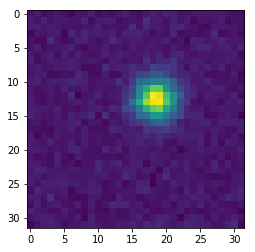

In [4]:
def logit17(x):
    x = (x + 17.) / 34.
    return np.log(x / (1. - x))


def logit5(x):
    x = (x - 0.2) / 4.85
    return np.log(x / (1. - x))


pars_true = np.array([logit17(3.), logit17(-3.), logit5(0.9)])
obs = g.model.gen_single(pars_true)
obs_stats = g.summary.calc([obs])

plt.imshow(obs_stats.reshape(isize, isize), interpolation='None')
plt.show()

In [5]:
inf = infer.SNPEC(generator=g, obs=obs_stats, **setup_opts)
log, trn_data, posteriors = inf.run(**run_opts)

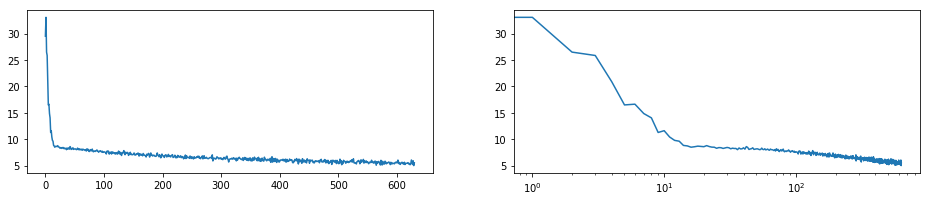

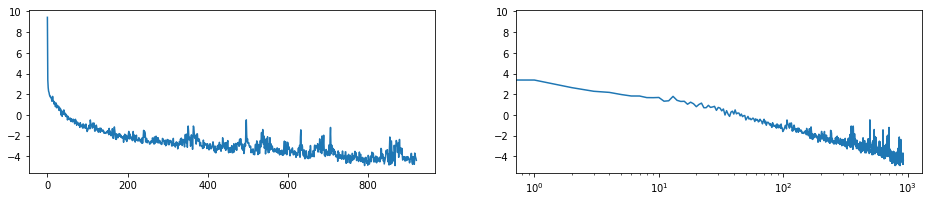

In [6]:
for r in range(run_opts['n_rounds']):
    plt.figure(figsize=(16,3))
    plt.subplot(1,2,1)
    plt.plot(log[r]['loss'])
    plt.subplot(1,2,2)
    plt.semilogx(log[r]['loss'])
    plt.show()

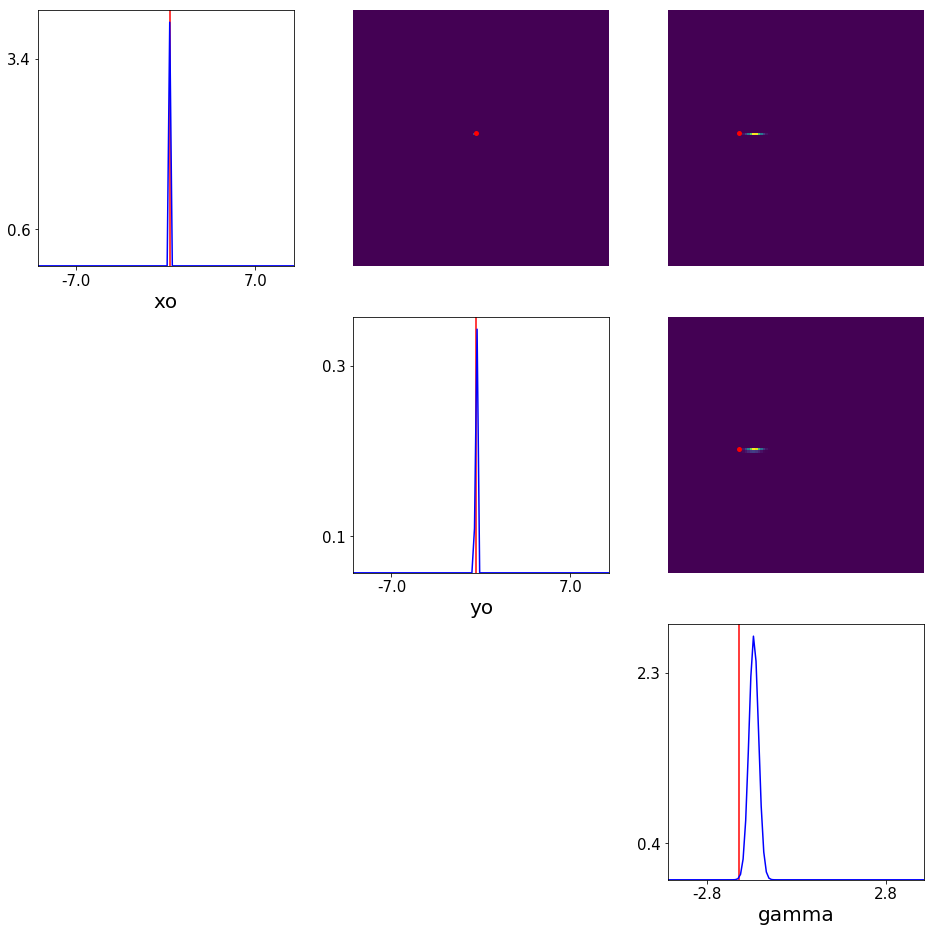

In [7]:
labels_params = ['xo', 'yo', 'gamma'] 
# all pairwise marginals of fitted posterior
fig, _ = plot_pdf(posteriors[-1], lims=[[-10, 10], [-10, 10], [-4, 4]], gt=pars_true.reshape(-1), figsize=(16,16), resolution=100,
                  labels_params=labels_params, ticks=True)